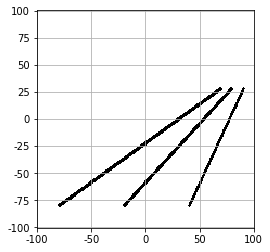

In [91]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

def proj_img(N): # Cria imagem branca 2N+1 x 2N+1 (centro em (N,N)), e imprime eixos x e y
    img = 255 * np.ones((2*N+1,2*N+1))
#    cv2.line(img, (0,N), (2*N,N), (0,0,0)) # eixo x
#    cv2.line(img, (N,0), (N,2*N), (0,0,0)) # eixo y
    plt.xticks(np.arange(0, 2*N+1, step=50), np.arange(-N, N+1, step=50))
    plt.yticks(np.arange(2*N, -1, step=-25), np.arange(-N, N+1, step=25))
    plt.grid(True)
    return img

N, f = 100, 100
perspectiva  = np.array([[f, 0, 0, 0],
                         [0, f, 0, 0],
                         [0, 0, 1, 0]])
points = [np.array([-200,-200,250]), np.array([-50,-200,250]), np.array([100,-200,250])]
d = 600 * np.array([2,1,2]) # converge para (f*d[0]/d[2], f*d[1]/d[2]) = f*(1,0.5) = (100,50)

img = proj_img(N)
for p in points:
    h = perspectiva.dot(np.append(p,1))
    p1 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
    p = np.add(p,d)
    h = perspectiva.dot(np.append(p,1))
    p2 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
    cv2.line(img, tuple(np.add([N,N],p1)), tuple(np.add([N,N],p2)), (0,0,0), 2)
plt.imshow(np.flip(img,0),'gray'); plt.show() # inverte eixo y

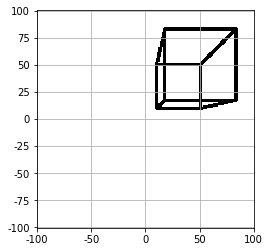

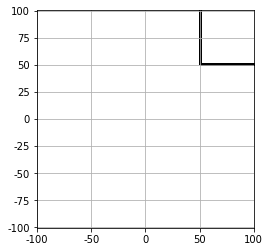

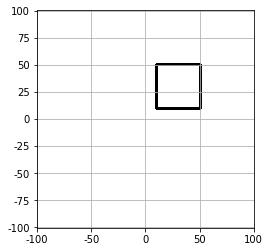

In [99]:
cubo = np.float32([ [[-1,-1,-1],[ 1,-1,-1]], [[-1,-1,-1],[-1, 1,-1]], [[ 1, 1,-1],[-1, 1,-1]], [[ 1, 1,-1],[ 1,-1,-1]],
                    [[-1,-1, 1],[ 1,-1, 1]], [[-1,-1, 1],[-1, 1, 1]], [[ 1, 1, 1],[-1, 1, 1]], [[ 1, 1, 1],[ 1,-1, 1]],
                    [[-1,-1,-1],[-1,-1, 1]], [[ 1,-1,-1],[ 1,-1, 1]], [[-1, 1,-1],[-1, 1, 1]], [[ 1, 1,-1],[ 1, 1, 1]] ])

perspectiva  = np.float32([[f, 0, 0, 0],
                           [0, f, 0, 0],
                           [0, 0, 1, 0]])
orthographic = np.float32([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 1]])
weak_persp   = np.float32([[1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 5]])

translacao = np.float32([150,150,400])
for M in [perspectiva, orthographic, weak_persp]:
    img = proj_img(N)
    for linha in cubo*100:
        p = np.add(linha[0],translacao)
        h = M.dot(np.append(p,1))
        p1 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
        p = np.add(linha[1],translacao)
        h = M.dot(np.append(p,1))
        p2 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
        cv2.line(img, tuple(np.add([N,N],p1)), tuple(np.add([N,N],p2)), (0,0,0), 2)
    plt.imshow(np.flip(img,0),'gray'); plt.show()

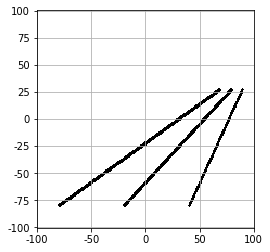

In [104]:
# Usando OpenCV para calcular a projeção

img = proj_img(N)

M = np.float32(perspectiva[:,:-1]) # Última coluna de 'perspectiva' não é utilizada
for p in np.float32(points):
    p1,jacob = cv2.projectPoints(np.array([p]), np.zeros(3), np.zeros(3), M, None)
    p2,jacob = cv2.projectPoints(np.array([np.add(p,d)]), np.zeros(3), np.zeros(3), M, None)
    cv2.line(img, tuple(np.add([N,N],p1.squeeze().astype(np.int))), tuple(np.add([N,N],p2.squeeze().astype(np.int))), (0,0,0), 2)

plt.imshow(np.flip(img,0),'gray'); plt.show()

[[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]


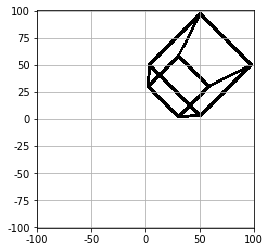

In [109]:
# Rodrigues: fornece matriz de rotação, recebendo o ângulo em cada eixo.
np.set_printoptions(precision=3,suppress=True)
rotacao = cv2.Rodrigues(np.float32([0,0,np.pi/4]))[0]
print(rotacao)

# Rotaciona os pontos antes de projetar
img = proj_img(N)
for linha in cubo*100:
    p = rotacao.dot(linha[0])
    p = np.add(p,translacao)
    h = perspectiva.dot(np.append(p,1))
    p1 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
    p = rotacao.dot(linha[1])
    p = np.add(p,translacao)
    h = perspectiva.dot(np.append(p,1))
    p2 = [int(np.rint(h[0]/h[2])), int(np.rint(h[1]/h[2]))]
    
    cv2.line(img, tuple(np.add([N,N],p1)), tuple(np.add([N,N],p2)), (0,0,0), 2)
plt.imshow(np.flip(img,0),'gray'); plt.show()

(3, 3)


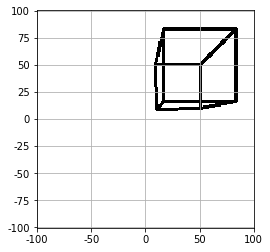

In [110]:
from IPython.display import clear_output
import time

def draw_lines(linhas3D, camera, rotacao=np.float32([0,0,0]), translacao=np.float32([0,0,0]), N=100):
    img = proj_img(N)
    for linha in linhas3D:
        p,jacob = cv2.projectPoints(linha, rotacao, translacao, camera, None)
        cv2.line(img, tuple(np.add([N,N],p[0].squeeze()).astype(int)), tuple(np.add([N,N],p[1].squeeze()).astype(int)), (0,0,0), 2)
    plt.imshow(np.flip(img,0),'gray'); plt.show()
        
def anima_rotacao(translacao=np.float32([0,0,0]), angulo=np.pi/2, steps=20, eixos=(0,0,1)):
    for u in range(steps+1):
        clear_output()
        rotacao = np.float32([eixos[0]*u*angulo/steps, eixos[1]*u*angulo/steps, eixos[2]*u*angulo/steps])
        print(perspectiva[:,:-1].shape)
        draw_lines(cubo*100, perspectiva[:,:-1], rotacao, translacao)
        time.sleep(0.5)    

anima_rotacao(translacao, eixos=(0,0,1))

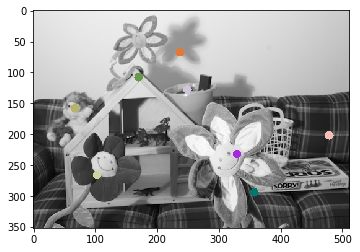

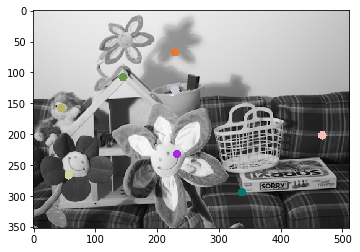

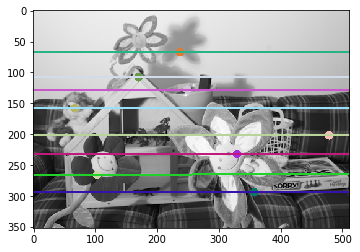

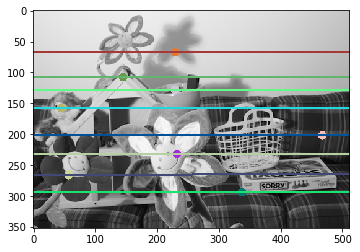

In [555]:
imgL = cv2.cvtColor(cv2.imread('images/flowers-left.png',0), cv2.COLOR_GRAY2BGR)
imgR = cv2.cvtColor(cv2.imread('images/flowers-right.png',0), cv2.COLOR_GRAY2BGR)

ptsL = np.array([(170,108), (357,294), (103,266), (249,128), (237,68), (329,232), (478,202), (67,158)])
ptsR = np.array([(145,108), (337,294),  (57,266), (229,128), (229,68), (232,232), (467,202), (45,158)])

for i in range(len(ptsL)):
    color = tuple(np.random.randint(0,255,3).tolist())
    cv2.circle(imgL, tuple(ptsL[i]), 7, color, -1)
    cv2.circle(imgR, tuple(ptsR[i]), 7, color, -1)
plt.imshow(cv2.cvtColor(imgL,cv2.COLOR_BGR2RGB)); plt.show()
plt.imshow(cv2.cvtColor(imgR,cv2.COLOR_BGR2RGB)); plt.show()

F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_RANSAC)
ptsL = ptsL[mask.ravel()==1] # Remove pontos não escolhidos pelo RANSAC. Com apenas 8 todos são escolhidos.
ptsR = ptsR[mask.ravel()==1]

# Impressão das linhas epipolares
c = imgL.shape[1]
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2),2,F).reshape(-1,3)
for r in linesL: # linha r = (r[0],r[1],r[2]), onde r[0]x + r[1]y + r[2] = 0.
    color = tuple(np.random.randint(0,255,3).tolist())
    cv2.line(imgL, (0,int(-r[2]/r[1])), (c,int(-(r[2]+r[0]*c)/r[1])), color,2)
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2),2,F).reshape(-1,3)
for r in linesR:
    color = tuple(np.random.randint(0,255,3).tolist())
    cv2.line(imgR, (0,int(-r[2]/r[1])), (c,int(-(r[2]+r[0]*c)/r[1])), color,2)

plt.imshow(cv2.cvtColor(imgL,cv2.COLOR_BGR2RGB)); plt.show()
plt.imshow(cv2.cvtColor(imgR,cv2.COLOR_BGR2RGB)); plt.show()

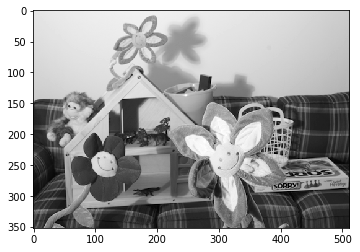

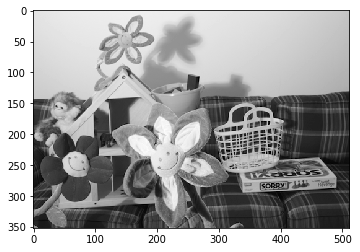

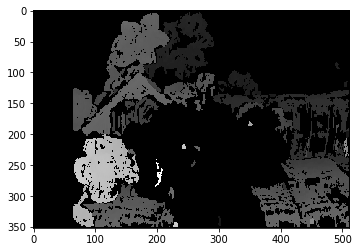

In [461]:
imgL = cv2.imread('images/flowers-left.png',0)
imgR = cv2.imread('images/flowers-right.png',0)
plt.imshow(imgL,'gray'); plt.show()
plt.imshow(imgR,'gray'); plt.show()

stereo = cv2.StereoBM_create(numDisparities=64, # Máximo de disparidades (em pixels) a serem testada 
                                                # acima de minDisparity. Perde esta qte de pixels no lado esq.
                                                # Múltiplo de 16. Flor da direita só aparece com 128.
                             blockSize=5) # Tamanho do bloco a ser comparado (ímpar). Menos ruído->Menos detalhes
#stereo.setMinDisparity(4) # Menor disparidade a ser testada. Default: 0
stereo.setSpeckleRange(4) # Máxima disparidade permitida em cada componente conexa. Será multiplicado por 16.
stereo.setSpeckleWindowSize(40) # Maior tam. de região suave que será considerada ruído (e removida).
# Mais detalhes em help(cv2.StereoSGBM_create) e help(cv2.StereoMatcher)

disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray'); plt.show()